In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [134]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [135]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First Block
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)   # fewer channels
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 12, kernel_size=3, padding=1)  # shrink 32→12
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(12)

        # Transition Layer 1
        self.pool = nn.MaxPool2d(2,2)
        self.antman1 = nn.Conv2d(12, 8, kernel_size=1)  # bottleneck

        # Second Block
        self.conv4 = nn.Conv2d(8, 12, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(12)
        self.conv5 = nn.Conv2d(12, 12, kernel_size=3, padding=1)  # instead of 32
        self.bn5 = nn.BatchNorm2d(12)


        #self.conv5addon = nn.Conv2d(20, 26, kernel_size=3, padding=1)
        #self.bn5addon = nn.BatchNorm2d(26)

        # Transition Layer 2
        self.pool2 = nn.MaxPool2d(2,2) # 7*7*12
        self.antman2 = nn.Conv2d(12, 8, kernel_size=1)  # shrink

        self.conv5addon = nn.Conv2d(8, 12, kernel_size=3, padding=1)
        self.bn5addon = nn.BatchNorm2d(12)

        # Final Conv
        self.conv6 = nn.Conv2d(12, 12, kernel_size=3, padding=1)

        # GAP + Classifier
        #self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(12*7*7, 16)
        #self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.05)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.antman1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.antman2(x)

        x = F.relu(self.bn5addon(self.conv5addon(x)))
        #x = self.antman2(x)

        x = self.conv6(x)

        #x = self.gap(x)
        x = x.view(x.size(0), -1)
        x =  self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [136]:

########### Calculating Total Number of Parameters #######################

model = Net()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 16570


In [137]:
#### DATA Pre Processing steps, DATA Augmentation  #########

#batch_size=200

train_transforms = transforms.Compose([
   # transforms.ToPILImage(),
    #transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation((-7.0 , 7.0), fill = (1, )),
    transforms.RandomAffine(0, translate=(0.02, 0.02)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) ## creating 1 epoch = batch_size of 200 images at a time
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [138]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) # changed from 0.01

scheduler = StepLR(optimizer, step_size=6, gamma=0.6)

In [139]:
model

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (antman1): Conv2d(12, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(ke

Here is the size of batch 2
Here is the size of each image in Mnist dataset torch.Size([64, 1, 28, 28]) && The size of batch is :  torch.Size([64])


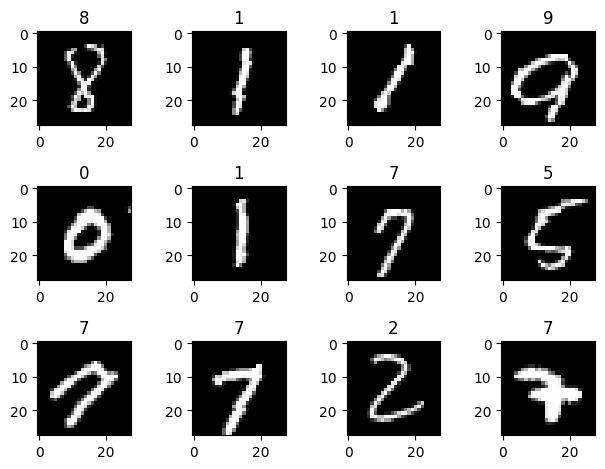

In [140]:
import matplotlib.pyplot as plt

queue=next(iter(train_loader))

print("Here is the size of batch",len(queue))

batch_data, batch_label = next(iter(train_loader)) #train loader=118 bayches which holds 512 images each 118*512

print("Here is the size of each image in Mnist dataset",batch_data.shape , "&& The size of batch is : ", batch_label.shape) #shape is an attribute here 512 * 1* 28 *28

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  #plt.xticks([])
  #plt.yticks([])


In [141]:
# 4. Training & Testing functions
# ------------------------------
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    print(f"Epoch {epoch}: Training Accuracy: {100. * correct / total:.2f}%")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [142]:
# Data to plot accuracy and loss graphs
#train_losses = []
#test_losses = []
#train_acc = []
#test_acc = []

#test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [143]:
###5. Run training & testing
# ------------------------------
from torch.optim.lr_scheduler import StepLR

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

for epoch in range(1, 21):  # train for 5 epochs
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    scheduler.step()   # 🔹 call this ONCE per epoch (after training+testing)
    #print(f"Epoch {epoch}: Learning rate is {scheduler.get_last_lr()}")



Epoch 1: Training Accuracy: 93.37%
Test set: Average loss: 0.0503, Accuracy: 98.34%
Epoch 2: Training Accuracy: 97.56%
Test set: Average loss: 0.0411, Accuracy: 98.65%
Epoch 3: Training Accuracy: 98.00%
Test set: Average loss: 0.0311, Accuracy: 98.85%
Epoch 4: Training Accuracy: 98.42%
Test set: Average loss: 0.0309, Accuracy: 98.91%
Epoch 5: Training Accuracy: 98.57%
Test set: Average loss: 0.0264, Accuracy: 99.17%
Epoch 6: Training Accuracy: 98.64%
Test set: Average loss: 0.0266, Accuracy: 99.08%
Epoch 7: Training Accuracy: 99.02%
Test set: Average loss: 0.0208, Accuracy: 99.31%
Epoch 8: Training Accuracy: 99.05%
Test set: Average loss: 0.0184, Accuracy: 99.35%
Epoch 9: Training Accuracy: 99.14%
Test set: Average loss: 0.0228, Accuracy: 99.28%
Epoch 10: Training Accuracy: 99.18%
Test set: Average loss: 0.0247, Accuracy: 99.13%
Epoch 11: Training Accuracy: 99.11%
Test set: Average loss: 0.0241, Accuracy: 99.21%
Epoch 12: Training Accuracy: 99.20%
Test set: Average loss: 0.0192, Accura

In [144]:
model = Net()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 16570
